## 6.5 Lab: Linear Models and Regularization
## Methods

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [4]:
!pip install l0bnb

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import Stepwise ,sklearn_selected ,sklearn_selection_path
from l0bnb import fit_path

## 6.5.1 Subset Selection Methods

In [8]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

59

In [9]:
Hitters = Hitters.dropna ();
Hitters.shape

(263, 20)

In [13]:
import numpy as np  # Make sure numpy is imported!

def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

# Example usage:
# sigma2 = 1.0  # some estimated error variance
# model = some_fitted_model
# X = some_input_matrix
# Y = some_output_vector
# score = nCp(sigma2, model, X, Y)

In [15]:
print(Hitters.columns.tolist())


['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']


In [16]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [17]:
neg_Cp = partial(nCp , sigma2)

In [18]:
strategy = Stepwise.first_peak(design ,
direction='forward',
max_terms=len(design.terms))

In [19]:
hitters_MSE = sklearn_selected(OLS ,
strategy)
hitters_MSE.fit(Hitters , Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [20]:
hitters_Cp = sklearn_selected(OLS ,
strategy ,
scoring=neg_Cp)
hitters_Cp.fit(Hitters , Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [21]:
strategy = Stepwise.fixed_steps(design ,
len(design.terms),
direction='forward')
full_path = sklearn_selection_path(OLS , strategy)

In [22]:
full_path.fit(Hitters , Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

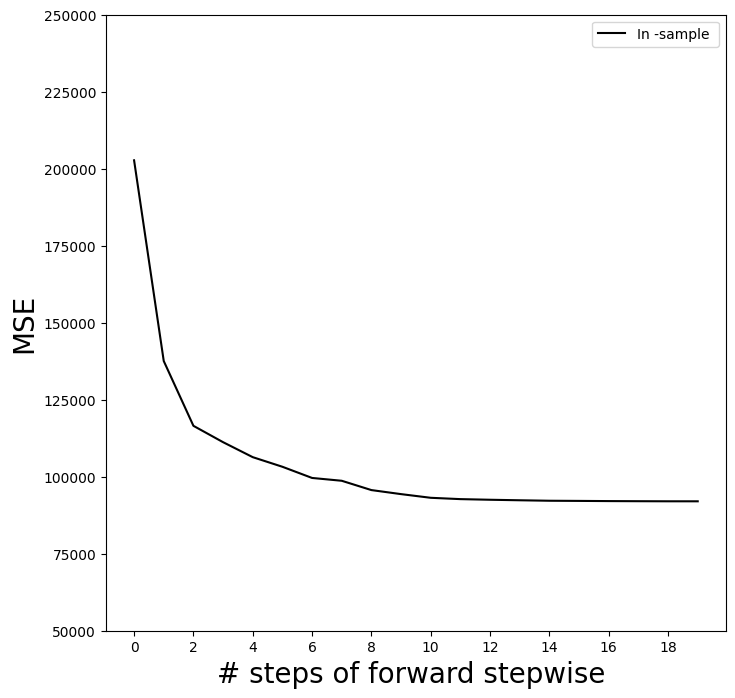

In [23]:
mse_fig , ax = subplots(figsize =(8 ,8))
insample_mse = (( Yhat_in - Y[:,None])**2).mean (0)
n_steps = insample_mse.shape [0]
ax.plot(np.arange(n_steps),
insample_mse ,
'k', # color black
label='In -sample ')
ax.set_ylabel('MSE',
fontsize =20)
ax.set_xlabel('# steps of forward stepwise ',
fontsize =20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend ()
ax.set_ylim ([50000 ,250000]);

In [24]:
K = 5
kfold = skm.KFold(K,
random_state =0,
shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path ,
Hitters ,
Y,
cv=kfold)
Yhat_cv.shape

(263, 20)

In [26]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx, None]) ** 2
    cv_mse.append(errors.mean(0))  # column means

cv_mse = np.array(cv_mse).T
cv_mse.shape


(20, 5)

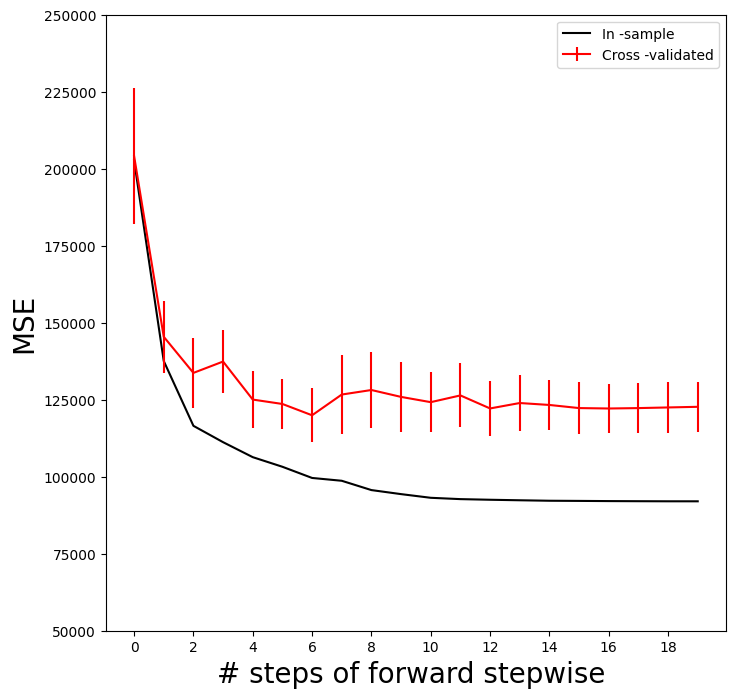

In [27]:
ax.errorbar(np.arange(n_steps),
cv_mse.mean (1),
cv_mse.std (1) / np.sqrt(K),
label='Cross -validated',
c='r') # color red
ax.set_ylim ([50000 ,250000])
ax.legend ()
mse_fig

In [29]:
validation = skm.ShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=0
)

for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None]) ** 2
    validation_mse = errors.mean(0)

# Check the resulting validation_mse
validation_mse


array([297431.06375465, 179409.9479167 , 169081.87136598, 161065.23003134,
       143343.94710477, 136980.48787987, 133308.92200721, 131281.92026823,
       123424.15486916, 122703.80987915, 125273.80434187, 127445.03843963,
       127856.74842777, 129173.2015285 , 129795.62564573, 123488.24024446,
       126038.61444479, 127633.64608344, 128992.90502241, 129058.63649627])

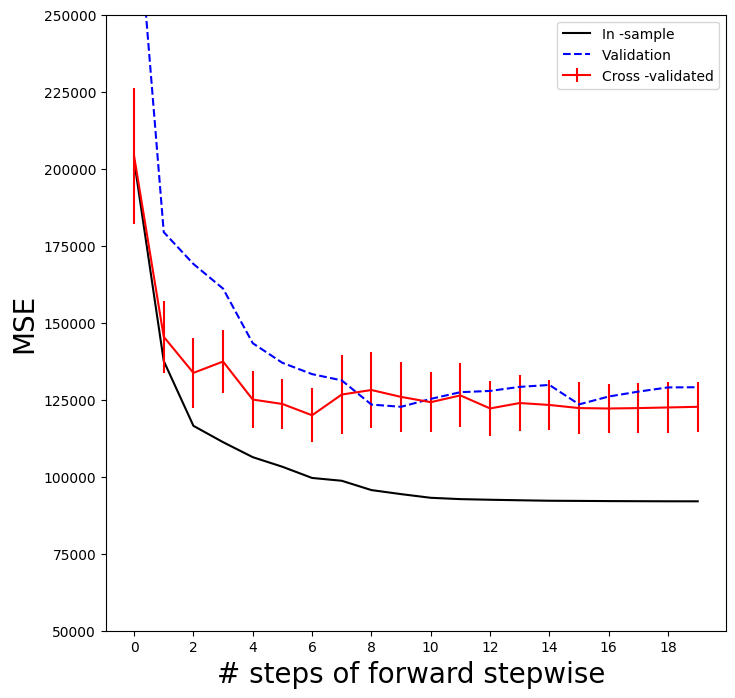

In [30]:
ax.plot(np.arange(n_steps),
validation_mse ,
'b--', # color blue , broken line
label='Validation ')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim ([50000 ,250000])
ax.legend ()
mse_fig

In [32]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis =1)
X = np.asarray(D)

In [33]:
path = fit_path(X,Y,max_nonzeros=X.shape [1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [34]:
path [3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.982167395555166,
 'lambda_0': 0.011416248027450197,
 'M': 0.5829861733382011,
 'Time_exceeded': False}

## 6.5.2 Ridge Regression and the Lasso

In [35]:
Xs = X - X.mean (0)[None ,:]
X_scale = X.std (0)
Xs = Xs / X_scale[None ,:]
lambdas = 10**np.linspace (8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs ,
Y,
l1_ratio =0.,
alphas=lambdas)[1]
soln_array.shape

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.443e+07, tolerance: 1.289e+04
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarn

(19, 100)

In [36]:
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns ,
index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


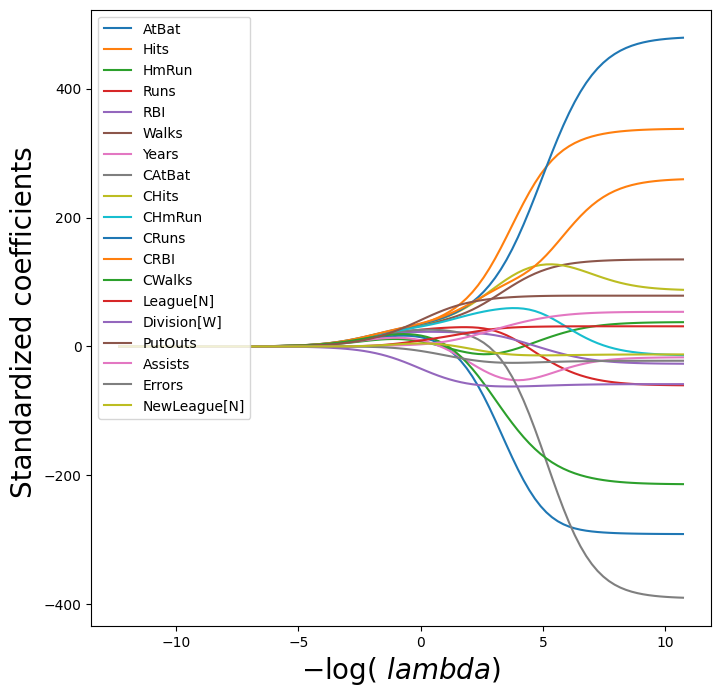

In [37]:
path_fig , ax = subplots(figsize =(8 ,8))
soln_path.plot(ax=ax , legend=False)
ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)
ax.set_ylabel('Standardized coefficients ', fontsize =20)
ax.legend(loc='upper left');

In [38]:
beta_hat = soln_path.loc[soln_path.index [39]]
lambdas [39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [39]:
np.linalg.norm(beta_hat)

24.170617201443783

In [40]:
beta_hat = soln_path.loc[soln_path.index [59]]
lambdas [59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.4237101772604)

In [41]:
ridge = skl.ElasticNet(alpha=lambdas [59], l1_ratio =0)
scaler = StandardScaler(with_mean=True , with_std=True)
pipe = Pipeline(steps =[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.24374766133488554
,l1_ratio,0
,fit_intercept,True
,precompute,False


In [42]:
np.linalg.norm(ridge.coef_)

160.42371017725932

In [43]:
validation = skm.ShuffleSplit(n_splits =1,
test_size =0.5,
random_state =0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge ,
X,
Y,
scoring='neg_mean_squared_error',
cv=validation)
-results['test_score']

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

In [44]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge ,
X,
Y,
scoring='neg_mean_squared_error',
cv=validation)
-results['test_score']

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

In [45]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe ,
param_grid ,
cv=validation ,
scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fa

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.005899006046740856
,l1_ratio,0
,fit_intercept,True
,precompute,False


In [47]:
grid = skm.GridSearchCV(pipe ,
param_grid ,
cv=kfold ,
scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fa

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.01185247763144249
,l1_ratio,0
,fit_intercept,True
,precompute,False


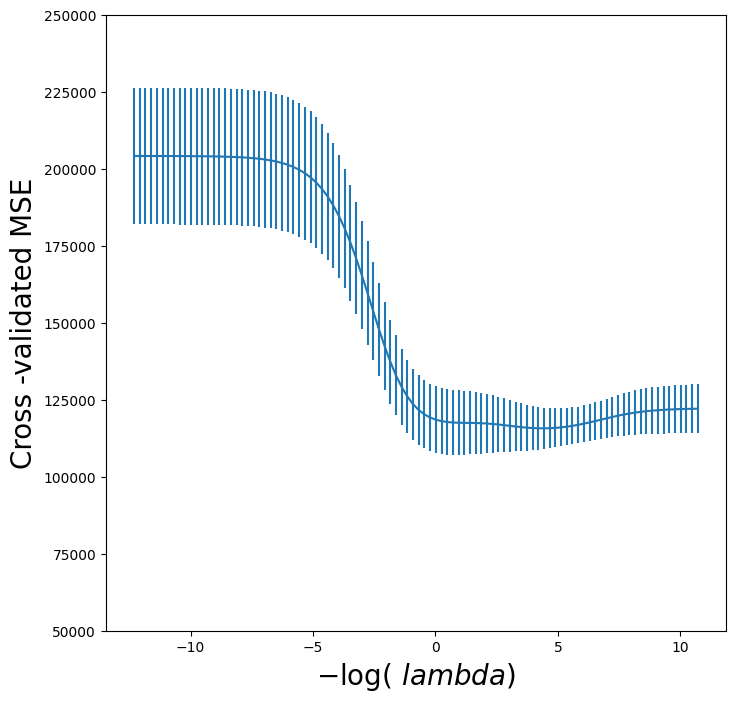

In [48]:
ridge_fig , ax = subplots(figsize =(8 ,8))
ax.errorbar(-np.log(lambdas),
-grid.cv_results_['mean_test_score'],
yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)
ax.set_ylabel('Cross -validated MSE', fontsize =20);

In [49]:
grid_r2 = skm.GridSearchCV(pipe ,
param_grid ,
cv=kfold)
grid_r2.fit(X, Y)

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fa

,estimator,Pipeline(step...l1_ratio=0))])
,param_grid,{'ridge__alpha': array([2.2209...22093791e-05])}
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


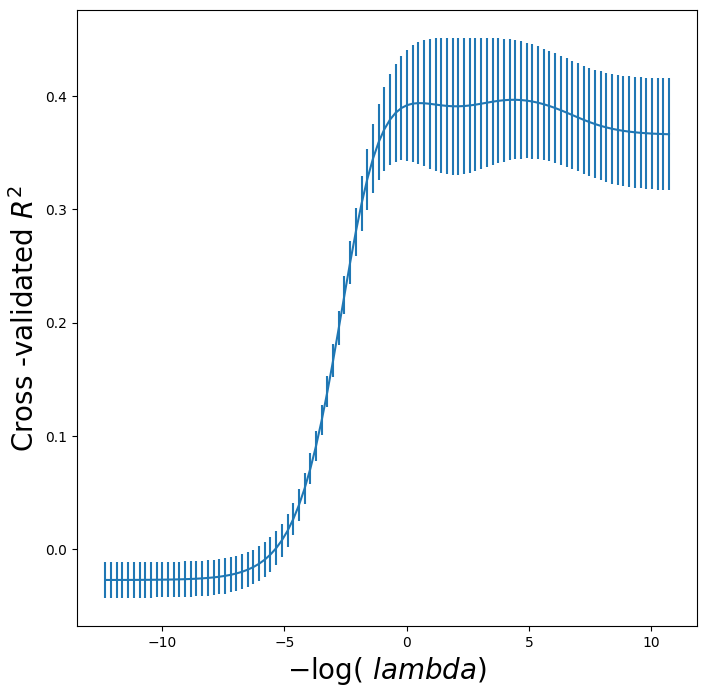

In [50]:
r2_fig , ax = subplots(figsize =(8 ,8))
ax.errorbar(-np.log(lambdas),
grid_r2.cv_results_['mean_test_score'],
yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
)
ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)
ax.set_ylabel('Cross -validated $R^2$', fontsize =20);

In [65]:
print(X.shape)  # (442, num_features)?
print(Y.shape)  # (263,)?


(442, 10)
(263,)


In [66]:
# Drop missing values for all columns including target
df = Hitters.dropna(subset=['Salary'])  # Drop rows where target is NaN

X = df.drop(columns='Salary')
Y = df['Salary']

print(X.shape, Y.shape)  # They must match


(263, 19) (263,)


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Drop missing target
Hitters = Hitters.dropna(subset=['Salary'])

# Drop the target column to define X and Y
Y = Hitters['Salary']
X = Hitters.drop(columns=['Salary'])

# ✅ One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)  # Converts strings like 'N'/'A' to 0/1 columns

print(X.shape, Y.shape)  # Confirm shapes match

# CV setup
scaler = StandardScaler()
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
lambdas = np.logspace(-4, 4, 50)

ridgeCV = ElasticNetCV(
    l1_ratio=0,  # Ridge
    alphas=lambdas,
    cv=kfold
)

pipeCV = Pipeline([
    ('scaler', scaler),
    ('ridge', ridgeCV)
])

pipeCV.fit(X, Y)

print("Best alpha:", pipeCV.named_steps['ridge'].alpha_)




(263, 19) (263,)


C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e+07, tolerance: 4.992e+03
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarn

Best alpha: 0.009102981779915217


C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.117e+07, tolerance: 5.055e+03
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.117e+07, tolerance: 5.055e+03
  model = cd_fast.enet_coordinate_descent_gram(
C:\Python310\lib\site-packages

In [55]:
print(pipeCV.named_steps.keys())


dict_keys(['scaler ', 'ridge '])


In [71]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_diabetes

# Example data — Replace this with your own X and y
data = load_diabetes()
X = data.data
y = data.target

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the parameter grid
lambdas = np.logspace(-4, 4, 50)  # candidate alphas
param_grid = {'model__alpha': lambdas}

# Set up pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

# KFold CV
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid search
pipeCV = GridSearchCV(
    pipe,
    param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# Fit the model
pipeCV.fit(X_train, y_train)

# Best alpha
best_alpha = pipeCV.best_params_['model__alpha']
print("Best alpha:", best_alpha)

# Test performance
test_score = pipeCV.score(X_test, y_test)
print("Test R^2 score:", test_score)







Best alpha: 0.8286427728546842
Test R^2 score: -2893.029828926229


In [81]:
outer_valid = skm.ShuffleSplit(n_splits =1,
test_size =0.25 ,
random_state =1)
inner_cv = skm.KFold(n_splits =5,
shuffle=True ,
random_state =2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
l1_ratio =0,
cv=inner_cv)
pipeCV = Pipeline(steps =[('scaler', scaler),
('ridge', ridgeCV)]);
